# Activate GPU if available

In [1]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")

# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using GPU: NVIDIA GeForce RTX 3080


# Setting up the dataset. It downloads and sets up a directory 'data' the first time this cell is executed

Total number of training images in subset: 60000
Total number of testing images in subset: 2000
Training data range: min = 0.0, max = 1.0
Testing data range: min = 0.0, max = 1.0
Loaded batch size: 64
Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])


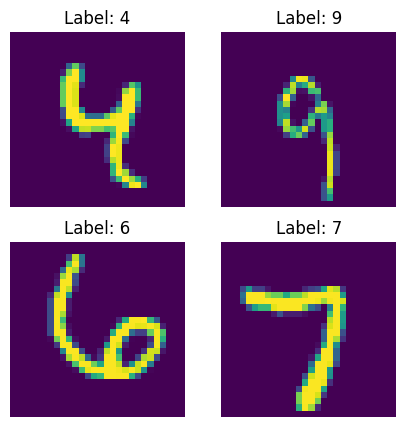

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load MNIST dataset with the new transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Subset the datasets to include only a set number of examples
num_samples_train = 60000  # Number of samples to include in the training subset
num_samples_test = 2000   # Number of samples to include in the testing subset

indices_train = np.random.choice(len(train_dataset), num_samples_train, replace=False)
indices_test = np.random.choice(len(test_dataset), num_samples_test, replace=False)

subset_train_dataset = Subset(train_dataset, indices_train)
subset_test_dataset = Subset(test_dataset, indices_test)

print(f"Total number of training images in subset: {len(subset_train_dataset)}")
print(f"Total number of testing images in subset: {len(subset_test_dataset)}")

# Create data loaders with subsets
train_loader = DataLoader(subset_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(subset_test_dataset, batch_size=64, shuffle=False)

# Function to check the range of pixel values in the dataset
def check_image_range(loader):
    min_val, max_val = float('inf'), float('-inf')
    for images, _ in loader:
        batch_min, batch_max = images.min().item(), images.max().item()
        min_val, max_val = min(min_val, batch_min), max(max_val, batch_max)
        # Break after the first batch if only a quick check is needed
        break
    return min_val, max_val

train_min, train_max = check_image_range(train_loader)
test_min, test_max = check_image_range(test_loader)

print(f"Training data range: min = {train_min}, max = {train_max}")
print(f"Testing data range: min = {test_min}, max = {test_max}")

# Example of accessing and plotting the first batch of images
for images, labels in train_loader:
    print(f"Loaded batch size: {images.shape[0]}")
    print(f"Images shape: {images.shape}")  # Shape of images in a batch
    print(f"Labels shape: {labels.shape}")  # Shape of labels in a batch

    # Displaying a few example images from the batch
    plt.figure(figsize=(5, 5))
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].squeeze(), cmap='viridis')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break  # Only process the first batch

# Initialize the model

tested with latent_dim_size = 4, 6, 8, 10, 15, 20, 32

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class EnhancedVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(EnhancedVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            self._conv_bn_relu(1, 32, 4, 2, 1),  # 28x28 -> 14x14
            self._conv_bn_relu(32, 64, 4, 2, 1),  # 14x14 -> 7x7
            self._conv_bn_relu(64, 128, 3, 2, 1),  # 7x7 -> 4x4
            self._conv_bn_relu(128, 256, 4, 1, 0)  # 4x4 -> 1x1
        )
        self.fc1 = nn.Linear(256, 512)
        self.fc21 = nn.Linear(512, latent_dim)  # Mean of latent variable
        self.fc22 = nn.Linear(512, latent_dim)  # Log variance of latent variable
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.fc4 = nn.Linear(512, 256)
        self.decoder = nn.Sequential(
            self._conv_transpose_bn_relu(256, 128, 4, 1, 0),  # 1x1 -> 4x4
            self._conv_transpose_bn_relu(128, 64, 3, 2, 1),  # 4x4 -> 7x7
            self._conv_transpose_bn_relu(64, 32, 4, 2, 1),  # 7x7 -> 14x14
            nn.ConvTranspose2d(32, 1, 4, 2, 1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )
        
        self._init_weights()

    def _conv_bn_relu(self, in_channels, out_channels, *args, **kwargs):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def _conv_transpose_bn_relu(self, in_channels, out_channels, *args, **kwargs):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, *args, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        h = F.leaky_relu(self.fc1(h), 0.2)
        return self.fc21(h), self.fc22(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.leaky_relu(self.fc3(z), 0.2)
        h = F.leaky_relu(self.fc4(h), 0.2)
        h = h.view(-1, 256, 1, 1)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, kld_weight=1.0):
    BCE = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + kld_weight * KLD

# Define latent dimension size
latent_dim_size = 20

# Initialize model and optimizer with the chosen latent dimension size

model = EnhancedVAE(latent_dim=latent_dim_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop

In [5]:
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Training loop
def train(model, optimizer, data_loader, epochs, device, log_interval=10, kld_weight=1.0):
    model.train()
    train_losses = []
    total_batches = len(data_loader) * epochs
    
    with tqdm(total=total_batches, desc='Training', unit='batch') as pbar:
        for epoch in range(1, epochs + 1):
            total_loss = 0
            for batch_idx, (data, _) in enumerate(data_loader):
                data = data.to(device)
                optimizer.zero_grad()
                recon_batch, mu, logvar = model(data)
                loss = loss_function(recon_batch, data, mu, logvar, kld_weight)
                loss.backward()
                total_loss += loss.item()
                optimizer.step()
                
                if (batch_idx + 1) % log_interval == 0:
                    pbar.set_postfix({'loss': loss.item() / len(data)})
                pbar.update(1)
            
            average_loss = total_loss / len(data_loader.dataset)
            train_losses.append(average_loss)
            pbar.set_description(f'Epoch {epoch}/{epochs}')
            # print(f'Epoch {epoch}, Average loss: {average_loss:.4f}')
    
    return train_losses

# Training the model
epochs = 100
log_interval = 50
kld_weight = 1

# Assuming model, optimizer, train_loader, and device are already defined
train_losses = train(model, optimizer, train_loader, epochs, device, log_interval, kld_weight)


Training:   0%|          | 0/93800 [00:00<?, ?batch/s]

# Plot the losses

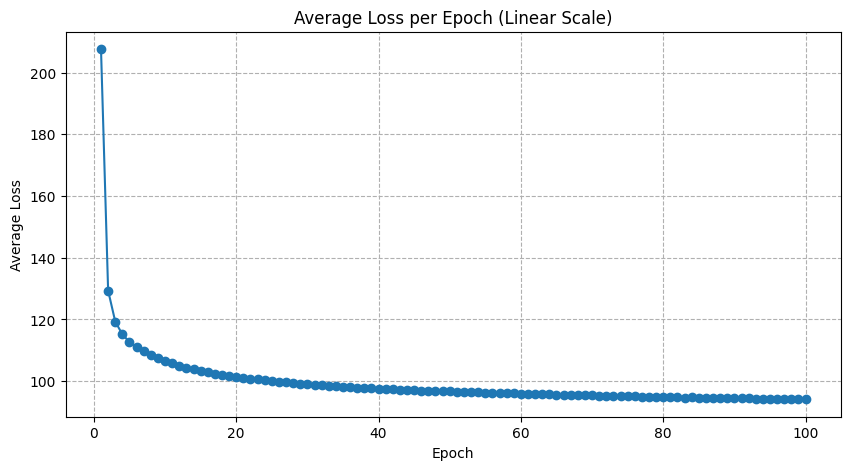

In [6]:
import matplotlib.pyplot as plt

# Function to plot the losses with a selectable y-axis scale
def plot_losses(losses, scale='log'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o')
    plt.title(f'Average Loss per Epoch ({scale.capitalize()} Scale)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.yscale(scale)
    plt.grid(True, which="both", ls="--")
    plt.show()

# Example usage
plot_losses(train_losses, scale='linear')  # Change 'log' to 'linear' for linear scale


# Display original and reconstructed images with labels

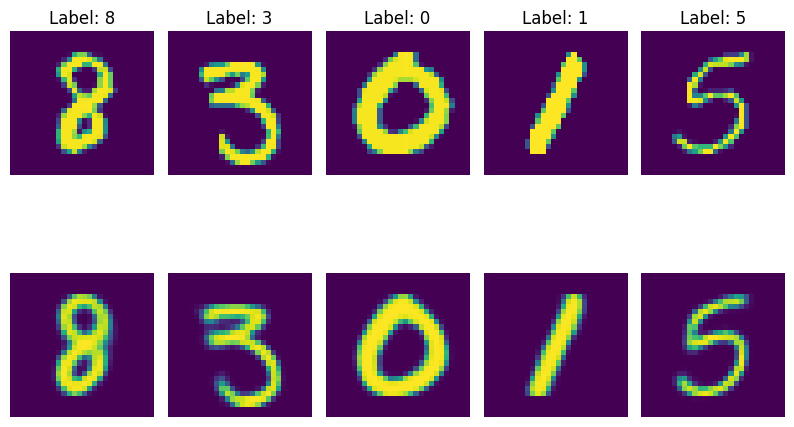

In [26]:
import random
import torch
import matplotlib.pyplot as plt

# Function to visualize results
def visualize_results(model, data_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.to(device)
            recon, _, _ = model(data)
            break

    # Randomly select num_images indices
    indices = random.sample(range(len(data)), num_images)

    # Display original and reconstructed images with labels
    plt.figure(figsize=(2 * num_images, 6))
    for i, idx in enumerate(indices):
        # Original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(data[idx].cpu().numpy().reshape(28, 28), cmap='viridis')
        plt.title(f'Label: {labels[idx].item()}')
        plt.xlabel('Original')
        plt.axis('off')

        # Reconstructed
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(recon[idx].cpu().numpy().reshape(28, 28), cmap='viridis')
        plt.xlabel('Reconstructed')
        plt.axis('off')

    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

# Example usage with variable number of images
num_images_to_display = 5
visualize_results(model, test_loader, num_images=num_images_to_display)


# Generate and visualize random numbers from a standard normal distribution

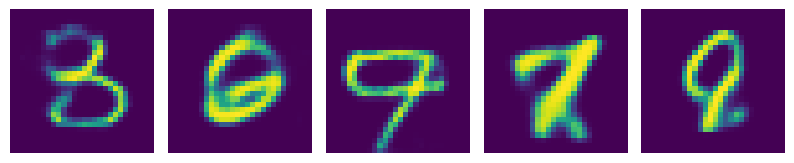

In [24]:
import torch
import matplotlib.pyplot as plt

# Function to generate and visualize random numbers
def generate_random_numbers(model, num_samples=10, latent_dim_size=latent_dim_size):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim_size).to(device)  # Sample from a standard normal distribution
        samples = model.decode(z).cpu()

    plt.figure(figsize=(2 * num_samples, 16))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(samples[i].numpy().reshape(28, 28), cmap='viridis')
        plt.axis('off')
    
    # Adjust spacing between subplots
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

# Generate and visualize random numbers
generate_random_numbers(model, num_samples=5)


# Extract latent space activations with testing subset

In [23]:
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm

# Function to extract latent space activations
def extract_latent_activations(model, data_loader, device):
    model.eval()
    activations = []

    with torch.no_grad():
        for data, labels in tqdm(data_loader, desc="Extracting latent activations"):
            data = data.to(device)
            mu, logvar = model.encode(data)
            latent_space = model.reparameterize(mu, logvar)
            
            for i in range(len(labels)):
                for j in range(latent_space.size(1)):
                    activations.append({
                        'Digit': labels[i].item(),
                        'Latent Neuron': j,
                        'Activation': latent_space[i, j].item()
                    })
    
    return pd.DataFrame(activations)

# Assuming train_loader is your DataLoader and model is your VAE model
df = extract_latent_activations(model, test_loader, device)


Extracting latent activations:   0%|          | 0/32 [00:00<?, ?it/s]

# Visualize the neuron activations for each digit as a heatmap and print out the prototype values

Digit prototypes are generated with testing subset

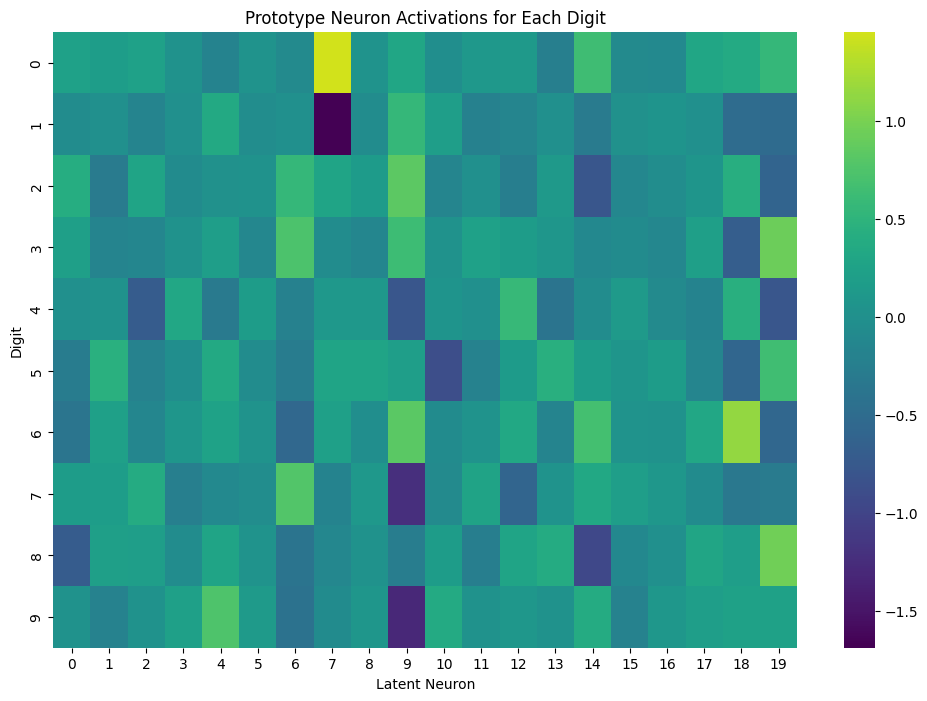

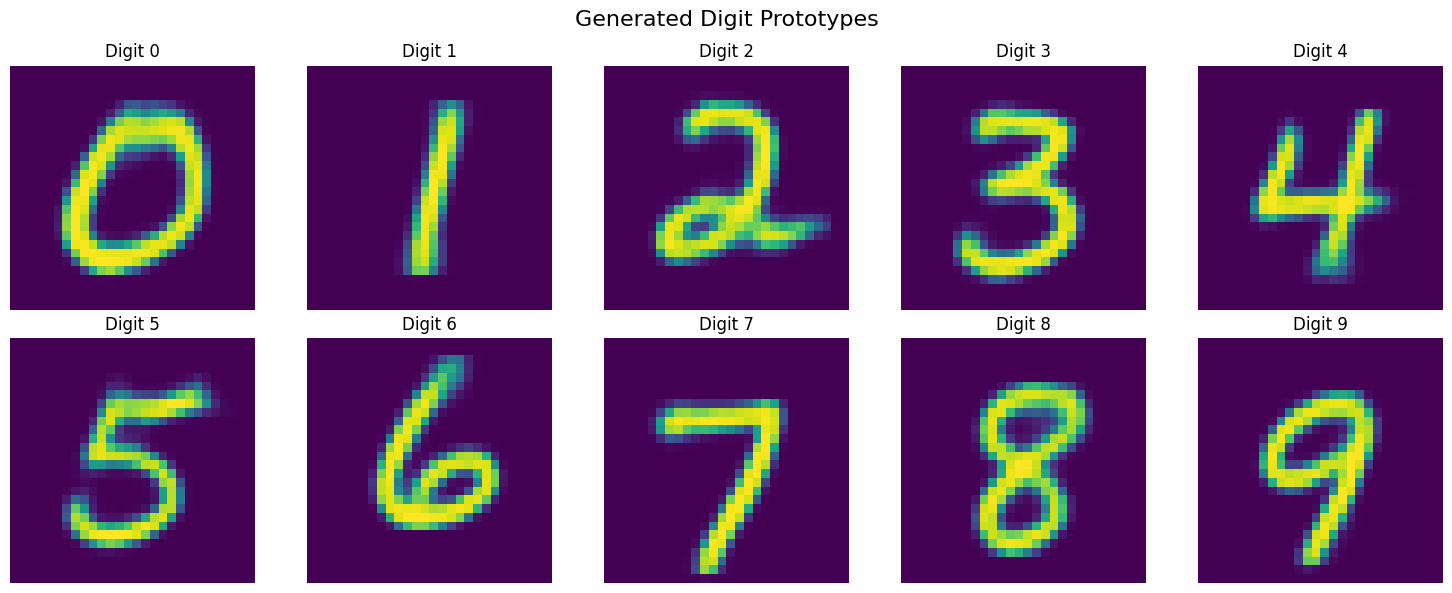

Digit 0:
neuron_values = {
    0: 0.231368,
    1: 0.166634,
    2: 0.234315,
    3: 0.020105,
    4: -0.167238,
    5: 0.046254,
    6: -0.091023,
    7: 1.452460,
    8: 0.049944,
    9: 0.304141,
    10: -0.031816,
    11: 0.104566,
    12: 0.119717,
    13: -0.245186,
    14: 0.637448,
    15: -0.090728,
    16: -0.094767,
    17: 0.309872,
    18: 0.356890,
    19: 0.551643,
}

Digit 1:
neuron_values = {
    0: -0.056788,
    1: 0.002852,
    2: -0.153852,
    3: -0.007357,
    4: 0.339189,
    5: -0.044305,
    6: -0.004724,
    7: -1.686507,
    8: -0.062159,
    9: 0.558223,
    10: 0.195235,
    11: -0.216179,
    12: -0.141813,
    13: -0.009071,
    14: -0.299344,
    15: 0.013457,
    16: 0.055920,
    17: -0.002673,
    18: -0.503168,
    19: -0.521551,
}

Digit 2:
neuron_values = {
    0: 0.398516,
    1: -0.289197,
    2: 0.275537,
    3: -0.072168,
    4: 0.011517,
    5: 0.037661,
    6: 0.549943,
    7: 0.276938,
    8: 0.143616,
    9: 0.832847,
    10: -0.141938,
  

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def calculate_digit_prototypes(df):
    # Compute average activations per neuron per digit
    prototypes = df.groupby(['Digit', 'Latent Neuron'])['Activation'].mean().unstack()
    return prototypes

def generate_prototype_images(model, prototypes, device):
    model.eval()
    with torch.no_grad():
        # Convert prototypes to tensor
        prototype_tensors = torch.tensor(prototypes.values, dtype=torch.float32).to(device)
        
        # Generate images
        generated_images = model.decode(prototype_tensors).cpu().numpy()
        
        # Plot the generated images
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for i, ax in enumerate(axes.flat):
            ax.imshow(generated_images[i].reshape(28, 28), cmap='viridis')
            ax.set_title(f"Digit {i}")
            ax.axis('off')
        
        plt.suptitle("Generated Digit Prototypes", fontsize=16)
        plt.tight_layout()
        plt.show()

# Calculate prototypes
prototypes = calculate_digit_prototypes(df)

# Display the prototypes as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(prototypes, cmap='viridis', center=0, annot=False, fmt='.2f')
plt.title('Prototype Neuron Activations for Each Digit')
plt.xlabel('Latent Neuron')
plt.ylabel('Digit')
plt.show()

# Generate and display prototype images
generate_prototype_images(model, prototypes, device)

# Print the prototype values for each digit in the specified format
for digit in range(10):
    print(f"Digit {digit}:")
    print(f"neuron_values = {{")
    for neuron, value in prototypes.loc[digit].items():
        print(f"    {neuron}: {value:.6f},")
    print("}\n")


# Iterate over selected neurons within a set value range

This visualization should help with understanding the feature mappings within selected neurons.

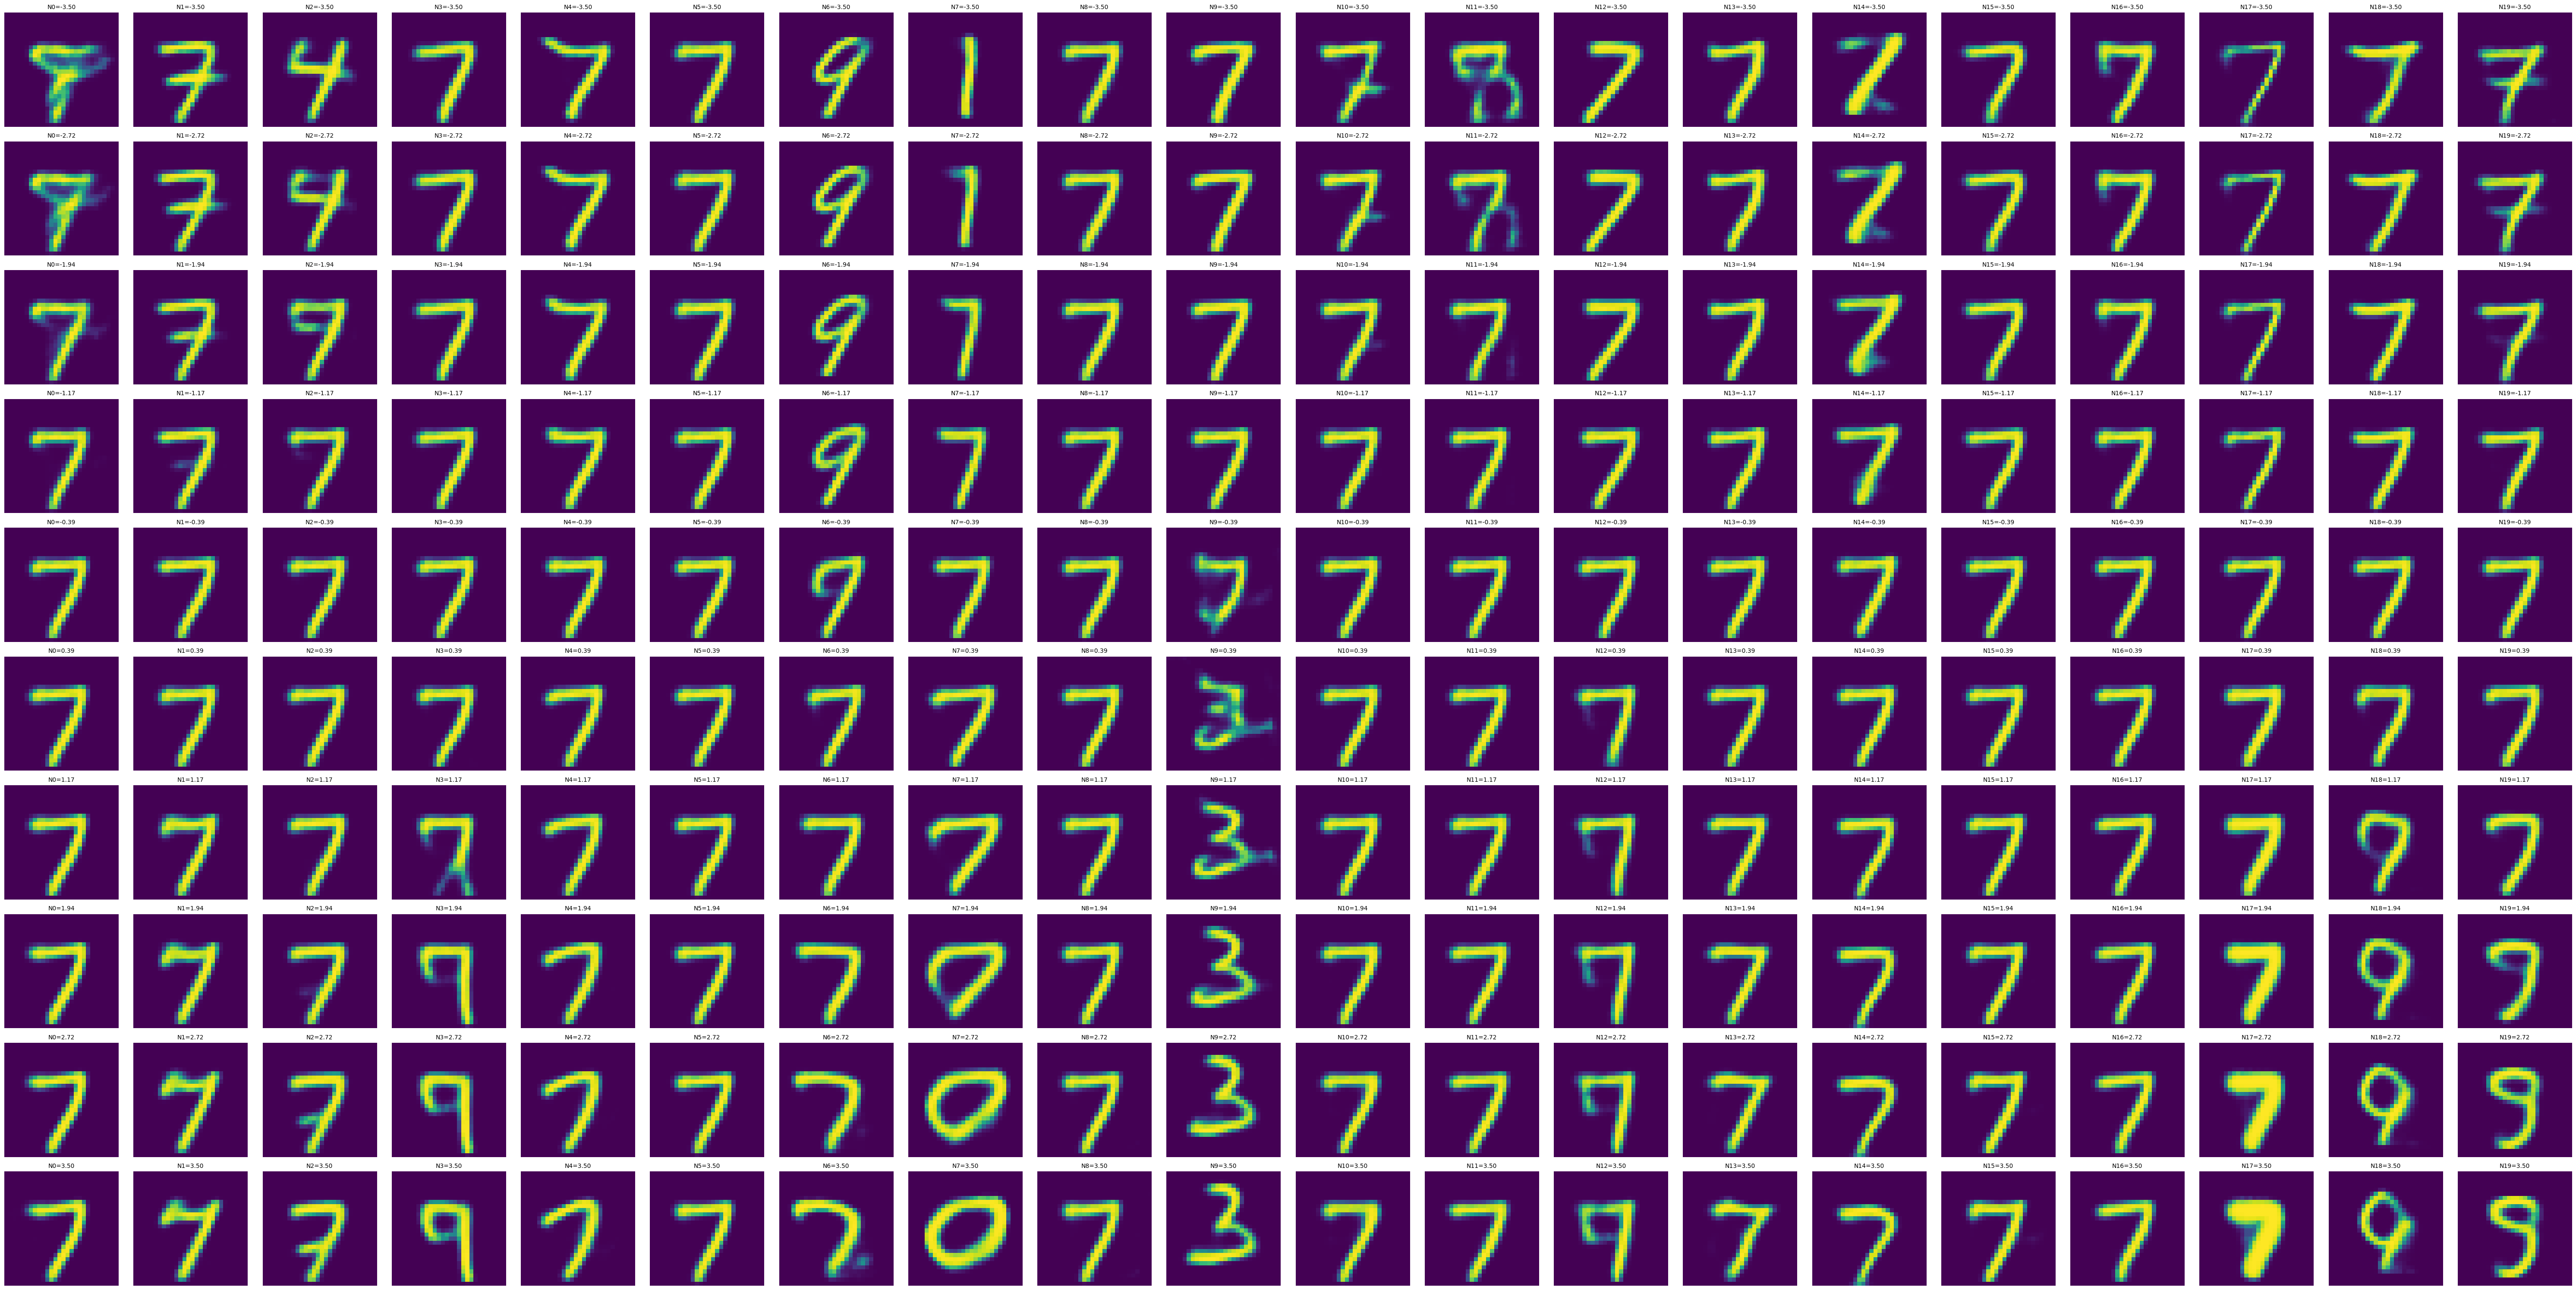

In [29]:
import matplotlib.pyplot as plt
import torch
from torch.distributions import Normal

def generate_images_with_neuron_progression(model, neurons_to_iterate, neuron_values, num_images=16, steps=11, start_value=-2, end_value=2):
    model.eval()
    with torch.no_grad():
        dist = Normal(0, 1)
        
        if neurons_to_iterate is all:
            neurons_to_iterate = list(neuron_values.keys())
        elif not isinstance(neurons_to_iterate, list):
            neurons_to_iterate = [neurons_to_iterate]
        
        num_neurons = len(neurons_to_iterate)
        fig, axes = plt.subplots(steps, num_neurons, figsize=(num_neurons*3, steps*3))
        
        # Ensure axes is always a 2D array
        if num_neurons == 1:
            axes = axes[:, None]
        
        for step in range(steps):
            z = dist.sample((num_images, model.latent_dim)).to(device)
            
            for neuron, value in neuron_values.items():
                z[:, neuron] = value
            
            iterated_value = start_value + (end_value - start_value) * step / (steps - 1)
            
            for col, neuron_to_iterate in enumerate(neurons_to_iterate):
                z_neuron = z.clone()
                z_neuron[:, neuron_to_iterate] = iterated_value
                
                generated_images = model.decode(z_neuron).cpu()
                
                ax = axes[step, col]
                ax.imshow(generated_images[0].squeeze(), cmap='viridis')
                ax.axis('off')
                ax.set_title(f"N{neuron_to_iterate}={iterated_value:.2f}", fontsize=10)
        
        manipulated_info = ", ".join([f"N{n}={v:.2f}" for n, v in neuron_values.items()])
        
        plt.tight_layout()
        plt.show()

# Example usage:
neuron_values = {
    0: 0.163478,
    1: 0.171513,
    2: 0.366408,
    3: -0.248767,
    4: -0.099981,
    5: -0.052977,
    6: 0.773115,
    7: -0.169637,
    8: 0.108731,
    9: -1.226008,
    10: -0.087037,
    11: 0.263965,
    12: -0.603821,
    13: 0.044845,
    14: 0.334784,
    15: 0.187314,
    16: 0.102578,
    17: -0.070477,
    18: -0.337167,
    19: -0.300399,
}
neurons_to_iterate = all  # Use 'all' to iterate over all neurons in neuron_values, a single neuron nuber or a list can be used as well
start_value = -3.5  # Start of the range
end_value = 3.5  # End of the range
generate_images_with_neuron_progression(model, neurons_to_iterate, neuron_values, num_images=1, steps=10, start_value=start_value, end_value=end_value)

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for data, target in dataloader:
            data = data.to(device)
            encoded = model.encode(data)
            
            if isinstance(encoded, tuple):
                latent = encoded[0]
            else:
                latent = encoded
            
            latent_representations.append(latent.cpu().numpy())
            labels.extend(target.numpy())
    
    return np.vstack(latent_representations), np.array(labels)

def plot_tsne(latent_representations, labels):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(latent_representations)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of latent space')
    plt.show()
    
def plot_pca(latent_representations, labels):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(latent_representations)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_results[:, 0], pca_results[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('PCA visualization of latent space')
    plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
    plt.show()

def plot_neuron_activations(model, dataloader, device, num_samples=100, filter_labels=None):
    model.eval()
    activations = []
    filtered_labels = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            if len(activations) >= num_samples:
                break
            
            if filter_labels is not None:
                mask = torch.tensor([label.item() in filter_labels for label in labels])
                if not mask.any():
                    continue
                data = data[mask]
                labels = labels[mask]
            
            data = data.to(device)
            encoded = model.encode(data)
            
            if isinstance(encoded, tuple):
                latent = encoded[0]
            else:
                latent = encoded
            
            activations.append(latent.cpu().numpy())
            filtered_labels.extend(labels.numpy())
    
    activations = np.vstack(activations)[:num_samples]
    filtered_labels = np.array(filtered_labels)[:num_samples]
    
    plt.figure(figsize=(14, 6))
    im = plt.imshow(activations.T, aspect='auto', cmap='viridis')
    plt.colorbar(im, label='Activation')
    plt.title(f'Neuron Activations for Selected Digits')
    plt.xlabel('Sample')
    plt.ylabel('Neuron')
    
    # Add a legend instead of individual labels
    unique_labels = np.unique(filtered_labels)
    legend_elements = [plt.Line2D([0], [0], color='w', marker='o', markersize=10,
                                  markerfacecolor=plt.cm.tab10(i / 10), label=f'Digit {label}')
                       for i, label in enumerate(unique_labels)]
    # plt.legend(handles=legend_elements, title="Digits", loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

def plot_neuron_histograms(model, dataloader, device, num_samples=1000, filter_labels=None):
    model.eval()
    activations = []
    filtered_labels = []
    
    with torch.no_grad():
        for data, labels in dataloader:
            if len(activations) >= num_samples:
                break
            
            if filter_labels is not None:
                mask = torch.tensor([label.item() in filter_labels for label in labels])
                if not mask.any():
                    continue
                data = data[mask]
                labels = labels[mask]
            
            data = data.to(device)
            encoded = model.encode(data)
            
            if isinstance(encoded, tuple):
                latent = encoded[0]
            else:
                latent = encoded
            
            activations.append(latent.cpu().numpy())
            filtered_labels.extend(labels.numpy())
    
    activations = np.vstack(activations)[:num_samples]
    filtered_labels = np.array(filtered_labels)[:num_samples]
    
    num_neurons = activations.shape[1]
    fig, axes = plt.subplots(6, 6, figsize=(20, 20))
    axes = axes.ravel()
    
    for i in range(min(36, num_neurons)):
        axes[i].hist(activations[:, i], bins=50)
        axes[i].set_title(f'Neuron {i}')
    
    plt.suptitle(f'Neuron Activation Histograms for Digits: {filter_labels if filter_labels else "All"}')
    plt.tight_layout()
    plt.show()

# Plot t-SNE nad PCA visualization

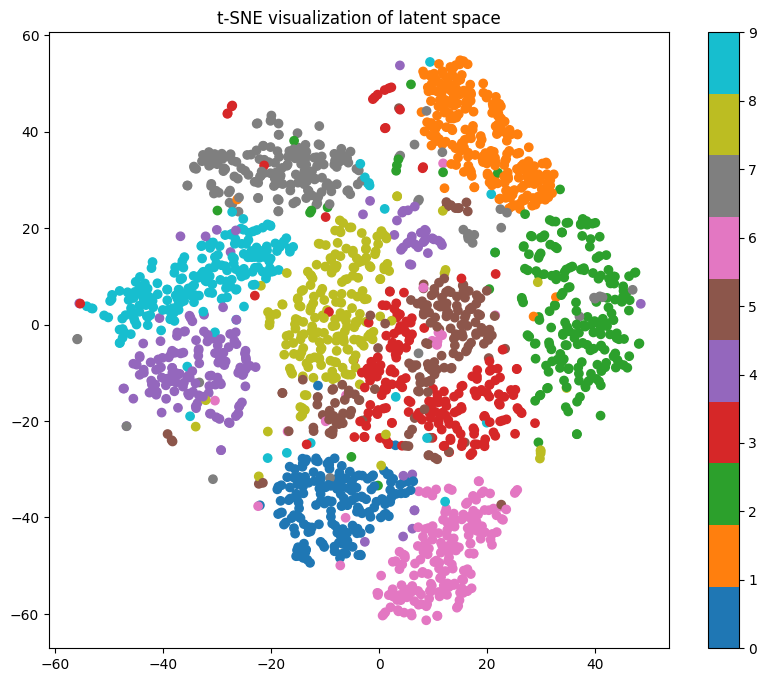

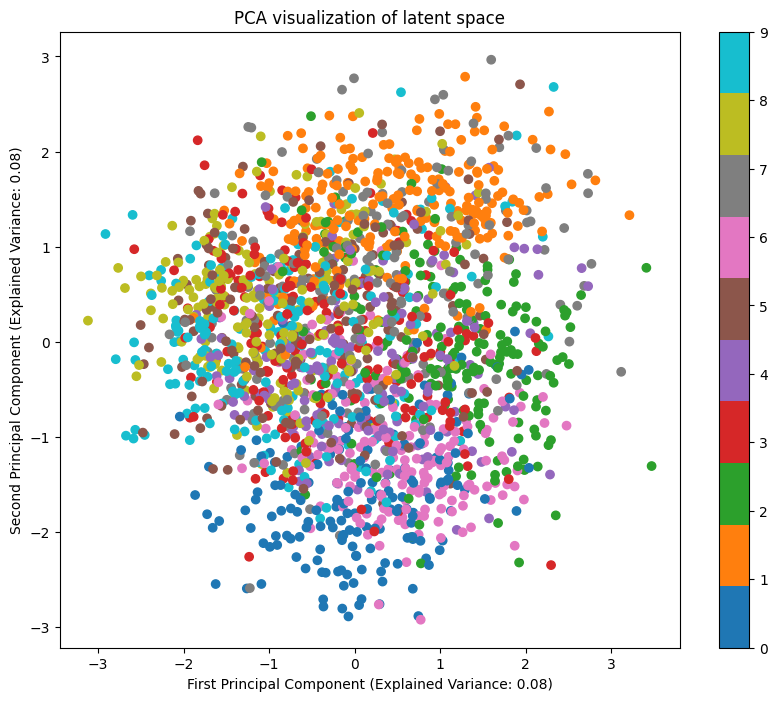

In [13]:
# t-SNE nad PCA visualization
latent_reps, labels = get_latent_representations(model, test_loader, device)
plot_tsne(latent_reps, labels)
plot_pca(latent_reps, labels)

# Plot Neuron activation heatmap and neuron activation histograms

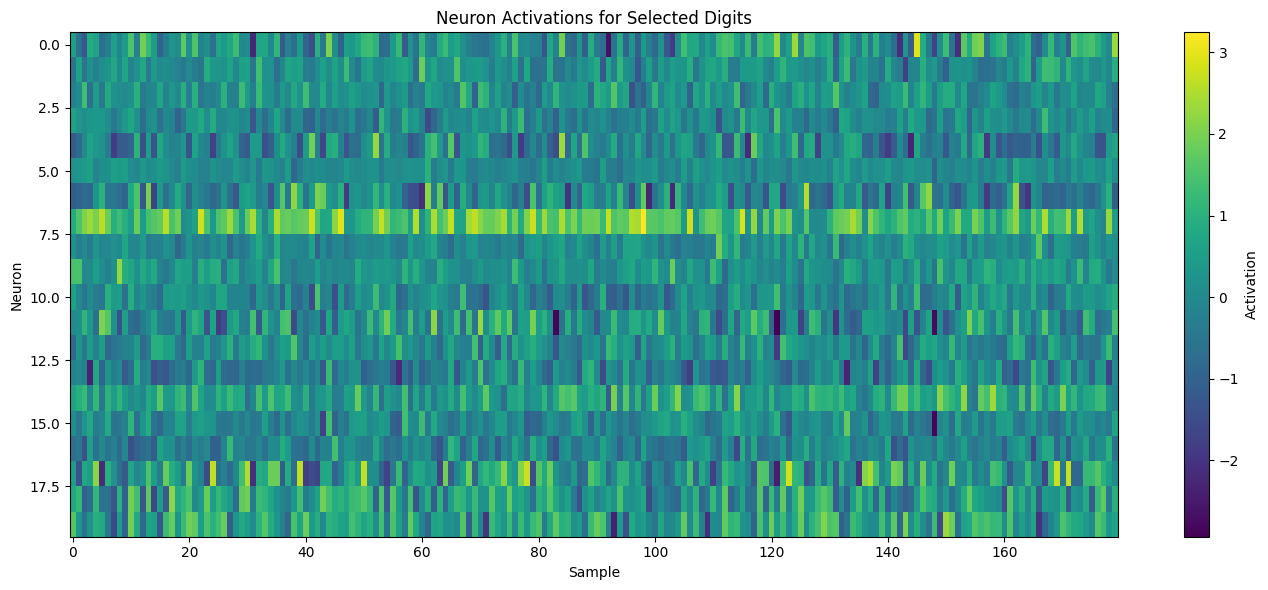

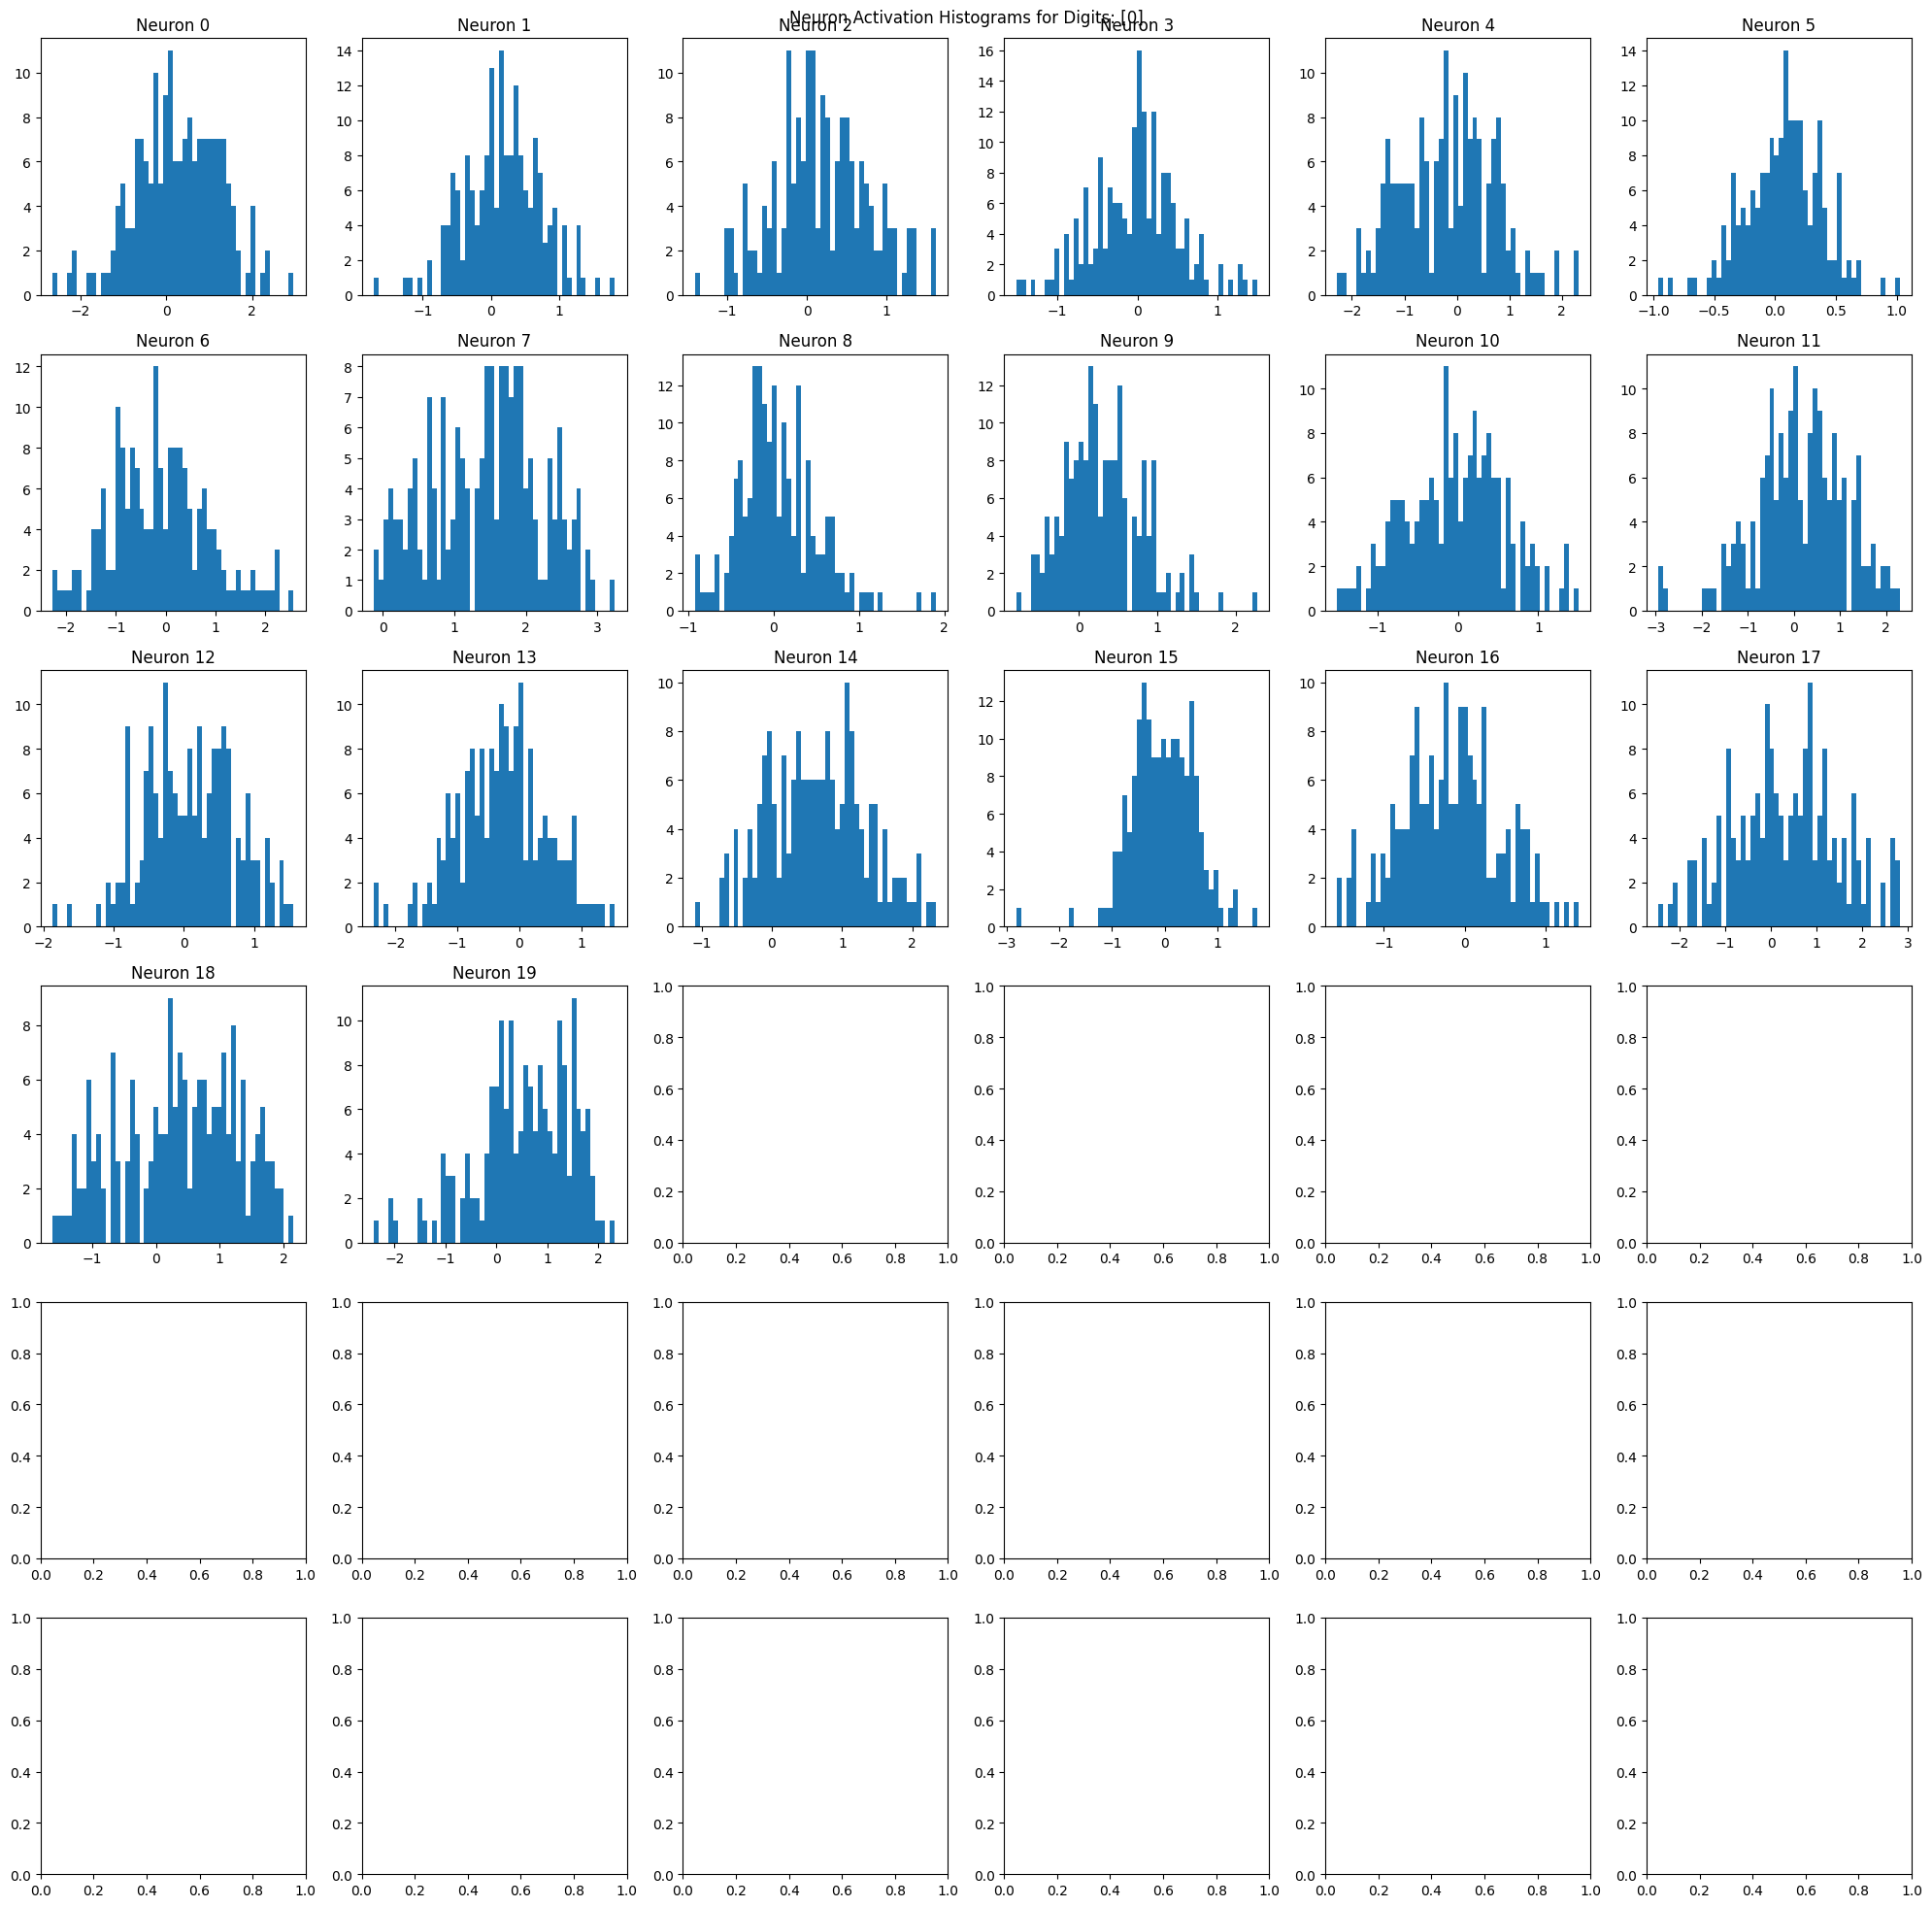

In [28]:
# Neuron activation heatmap 
plot_neuron_activations(model, test_loader, device, num_samples=200, filter_labels=[0])

# Neuron activation histograms
plot_neuron_histograms(model, test_loader, device, num_samples=200, filter_labels=[0])

# To see all digits, simply omit the filter_labels parameter or set it to None
# plot_neuron_activations(model, test_loader, device, num_samples=100)
# plot_neuron_histograms(model, test_loader, device, num_samples=1000)

# Save the current model

In [15]:
import torch

# Save the model weights
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Example usage after training
model_path = 'vae_model_gauss_enh20.pth'
save_model(model, model_path)


# Load a model

Make sure you run and setup the cell with the corresponding model first or you'll get errors.

In [4]:
import torch

# Load the model weights
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode

# Example usage before inference or further training
model_path = 'vae_model_gauss_enh20.pth'
load_model(model, model_path)
